In [85]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [86]:
bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

bastion_username = 'minawm_0041350787'

bastion_key_filename = os.environ['HOME'] + "/work/mina_bastion_key" #"/.ssh/id_rsa_fabric"

ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [87]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [88]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [89]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 180/192 , ram: 1,476/1,536 G, disk: 60,300/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 378/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 316/320 , ram: 2,544/2,560 G, disk: 116,380/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { 

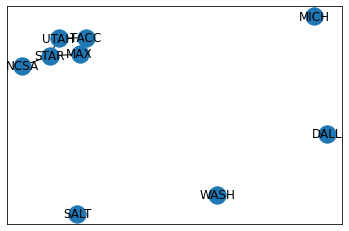

In [90]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice
In Release 1.0, user is expected to create tagged interface and assign the IP addresses manually. Please use the example comands indicated below:

## Configure Slice Parameters



In [91]:
slice_name = 'MySlice1'
site = 'MAX'
node1_name = 'Node1'
username='ubuntu'
image = 'default_ubuntu_20'
image_type = 'qcow2'
cores = 2
ram = 8
disk = 10

In [92]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name=node1_name, site=site)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
n1.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                            slice_graph=slice_graph, 
                                            ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: f274e680-c7e4-4629-8b06-0d0f1d1b26a6


## Get the Slice

In [93]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    


return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
    slice = wait_for_slice(slice, progress=True)

print()
print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice ....... Slice state: StableOK

Slice Name : MySlice1
ID         : f274e680-c7e4-4629-8b06-0d0f1d1b26a6
State      : StableOK
Lease End  : 2021-12-29 07:13:46


## Get the Nodes

Retrieve the node information and save the management IP address.


### Get the Topology

In [94]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

In [95]:
node1 = experiment_topology.nodes[node1_name]

management_ip_node1 = str(node1.get_property(pname='management_ip'))
print("Node Name        : {}".format(node1.name))
print("Management IP    : {}".format(management_ip_node1))
print()


Node Name        : Node1
Management IP    : 63.239.135.89



In [98]:
from ipaddress import ip_address, IPv4Address
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

import paramiko
management_ip = management_ip_node1

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

bastion=paramiko.SSHClient()
bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename)


bastion_transport = bastion.get_transport()
if validIPAddress(management_ip) == 'IPv4':
    src_addr = (bastion_private_ipv4_addr, 22)
elif validIPAddress(management_ip) == 'IPv6':
    src_addr = (bastion_private_ipv6_addr, 22)
else:
    print('Management IP Invalid: {}'.format(management_ip))

dest_addr = (management_ip, 22)
bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

client.connect(management_ip,username=username,pkey = key, sock=bastion_channel)

## Below is openwhisk and openwhisk cli installation

In [107]:
stdin, stdout, stderr = client.exec_command('sudo apt update && sudo apt install -y default-jre default-jdk')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('sudo apt install -y nodejs')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('sudo apt install -y npm')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo gpg --dearmor -o /usr/share/keyrings/docker-archive-keyring.gpg')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('echo   "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/docker-archive-keyring.gpg] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable" | sudo tee /etc/apt/sources.list.d/docker.list > /dev/null')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('sudo apt update && sudo apt install -y docker-ce docker-ce-cli containerd.io')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('git clone https://github.com/apache/openwhisk.git')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('tmux new-session -d -s "s1" "cd openwhisk/ && sudo ./gradlew core:standalone:bootRun"')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
# The above command takes a while to finish. But it will run in the background.
stdin, stdout, stderr = client.exec_command('/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('echo \'eval "$(/home/linuxbrew/.linuxbrew/bin/brew shellenv)"\' >> /home/ubuntu/.profile')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('eval "$(/home/linuxbrew/.linuxbrew/bin/brew shellenv)"')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('/home/linuxbrew/.linuxbrew/bin/brew install wsk')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('/home/linuxbrew/.linuxbrew/bin/wsk property set --apihost http://172.17.0.1:3233')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
stdin, stdout, stderr = client.exec_command('/home/linuxbrew/.linuxbrew/bin/wsk -i property set --auth 23bc46b1-71f6-4ed5-8c54-816aa4f8c502:123zO3xZCLrMN6v2BKK1dXYFpXlPkccOFqm12CdAsMgRU4VrNZ9lyGVCGuMDGIwP')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 https://download.docker.com/linux/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists...
Building dependency tree...
Reading state information...
79 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
default-jdk is already the newest version (2:1.11-72).
default-jre is already the newest version (2:1.11-72).
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.

Reading package lists...
Building dependency tree...
Reading state information...
nodejs is already the newest version (10.19.0~dfsg-3ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.

Reading package lists...
Building d

## Then, we can create an action like below.

In [108]:
stdin, stdout, stderr = client.exec_command('echo "def main(dict1):\n  return {\'key1\':\'Hello World!\'}" > action1.py')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

In [109]:
stdin, stdout, stderr = client.exec_command('/home/linuxbrew/.linuxbrew/bin/wsk action create action1 action1.py')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))
print (str(stderr.read(),'utf-8').replace('\\n','\n'))

ok: created action action1




## And then, below, we invoke the action we've created.

In [110]:
stdin, stdout, stderr = client.exec_command('/home/linuxbrew/.linuxbrew/bin/wsk action invoke action1 --result')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

{
    "key1": "Hello World!"
}



## Delete Slice

In [111]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
